# King County house sale datbase 2000-2023

## 1 Data preparation

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import kagglehub

c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

In [3]:
current_path = os.getcwd()
db_path = os.path.join(current_path, "db")

### 1.1 Population, income and other household data of cities and towns with a population of 5,000 or more

In [ ]:
# combine downloaded flatfiles
city_pop_dirs = os.listdir(os.path.join(db_path, "population"))
pop_sum = pd.DataFrame()
for pop_path in city_pop_dirs:
    pop = pd.read_csv(os.path.join(db_path, "population", pop_path), compression="gzip")
    pop.drop(columns=[a for a in pop.columns if "Note" in a], inplace=True)
    pop.drop(pop.iloc[64:].index, inplace=True)
    
    pop_sum = pd.concat([pop_sum,pop.set_index("Fact").transpose()])
    

In [5]:
pop_sum = pop_sum.sort_index().reset_index()
pop_sum =pop_sum.rename(columns={'index':"city"})
pop_sum["city"] = pop_sum["city"].str.replace(" city, Washington",'')

In [7]:
pop_sum = pop_sum.replace("S", np.nan).replace("X", np.nan).replace("D", np.nan)
pop_sum = pop_sum.drop(columns="FIPS Code")

C:\Users\xueke\AppData\Local\Temp\ipykernel_79556\3633105243.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pop_sum = pop_sum.replace("S", np.nan).replace("X", np.nan).replace("D", np.nan)


In [ ]:
# 
for col in pop_sum.columns:
    if col == "city" or pop_sum[col].dtype == "float64":
        pass
    else:
        pop_sum[col] = pop_sum[col].extract(r"[-+]?\d*\.?\d+")
        if "percent" in col or " rate" in col:
            pop_sum[col] = pd.to_numeric(pop_sum[col].str.replace('%', ''), errors='coerce') / 100

        else:
            pop_sum[col] = pd.to_numeric(pop_sum[col], errors='raise')

In [9]:
pop_sum.columns = [a.replace(" ","_")
                   .replace(",","")
                   .replace("'s","")
                    for a in pop_sum.columns]

In [10]:
pop_sum_highlight = pop_sum[[
        'city', 
       'Population_Census_April_1_2020',
       'Population_per_square_mile_2020', 
       'Land_area_in_square_miles_2020', 
        'Median_household_income_(in_2022_dollars)_2018-2022',
        'Per_capita_income_in_past_12_months_(in_2022_dollars)_2018-2022',
       'Households_2018-2022', 
       'Persons_per_household_2018-2022',

        'Median_gross_rent_2018-2022', 
       'Owner-occupied_housing_unit_rate_2018-2022',
       'Median_value_of_owner-occupied_housing_units_2018-2022',
       'Median_selected_monthly_owner_costs_-with_a_mortgage_2018-2022',
       'Median_selected_monthly_owner_costs_-without_a_mortgage_2018-2022',

       'Living_in_same_house_1_year_ago_percent_of_persons_age_1_year+_2018-2022',
        'Persons_in_poverty_percent',
       'Households_with_a_computer_percent_2018-2022',
       'Households_with_a_broadband_Internet_subscription_percent_2018-2022', 
        'Bachelor_degree_or_higher_percent_of_persons_age_25_years+_2018-2022',
       ]]

In [11]:
# pop_sum_highlight.to_csv("kc_population_income_detail.csv", index=False)

In [12]:
city_list = [a for a in pop_sum_highlight["city"]]

### 1.2 US inflation rate

In [ ]:
df_inf = pd.read_csv(os.path.join(db_path, "united-states-inflation-rate-cpi.csv.gz"), compression="gzip",header=6)

In [14]:
# rename columns, select 2000-2023 data
df_inf = df_inf.drop(columns=[" Annual % Change"])
df_inf = df_inf.rename(columns={' GDP (Billions of US $)': "Infaltion_%", ' Per Capita (US $)': "Annual_Change_%"})
df_inf["Date"] = pd.to_datetime(df_inf["Date"])
df_inf = df_inf[df_inf["Date"] > "1999-12-31"]

In [15]:
# calculate accumulated inflation
df_inf["Accumulated_inflation"] = ((df_inf["Infaltion_%"]/100+1).cumprod() - 1)*100
df_inf["Date"] = df_inf["Date"].dt.year
df_inf["year_base"] = df_inf["Accumulated_inflation"].shift(1)
df_inf["year_base"] =df_inf["year_base"].fillna(0)
df_inf["agg_diff"] = df_inf["Accumulated_inflation"] - df_inf["year_base"]

In [16]:
# df_inf.to_csv("US_inflation_2000-2023.csv", index=False)

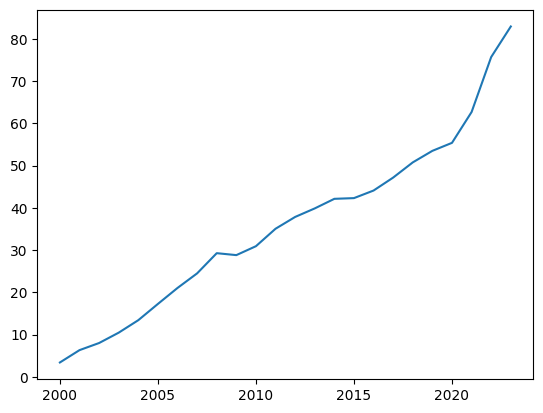

In [17]:
plt.plot(df_inf.set_index("Date")["Accumulated_inflation"])
plt.show()

### 1.3 House sales data

In [ ]:
df_01 = pd.read_csv(os.path.join(db_path, "kingco_sales.csv"+ ".gz"), compression="gzip")
df_02 = pd.read_csv(os.path.join(db_path, "kingcountysales.csv"+ ".gz"), compression="gzip")
df_03 = pd.read_csv(os.path.join(db_path, "kingcountysales_2000_2023.csv"+ ".gz"), compression="gzip")

df_kc_house = pd.concat([df_01, df_02, df_03])
df_kc_house.shape

(1709656, 49)

In [19]:
# PINX (Public Index) in house sales refers to an information database (administered by the King County Recorder's Office) of publicly recorded real estate property history.
df_kc_house = df_kc_house.drop(columns=["Unnamed: 0"])
df_kc_house = df_kc_house.drop_duplicates(["sale_id", "pinx"], keep="first")

In [20]:
# filtered properties only for single-family residential use
# Code 2: Might represent single-family residential use.
# Code 29: Could be a specific type of agricultural use or possibly a mixed-use category.
# Code 6: Might indicate a commercial property
df_kc_house = df_kc_house[df_03["present_use"]==2]

C:\Users\xueke\AppData\Local\Temp\ipykernel_79556\1942432278.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_kc_house = df_kc_house[df_03["present_use"]==2]


In [21]:
#remove unreasonable data
df_kc_house = df_kc_house[(df_kc_house["latitude"] < 100) &(df_kc_house["longitude"] < 0)]


In [22]:
df_kc_house.shape

(133733, 48)

Drop unrelated columns

In [23]:
# imp_val:Improved Value, This represents the value of a property including any enhancements made through construction or improvement that increases the property's market value. These enhancements can be physical (like buildings or structures added to a land parcel) or infrastructural (such as better access roads, utilities, etc.).
# sqft_lot:area of land
# sqft: area of indoor, and over ground
# fbsmt:finished basement
# wfnt: waterfront
df_kc_house = df_kc_house.drop(columns=["join_status", "join_year", "sale_nbr", "sale_warning", "present_use"])
df_kc_house = df_kc_house.drop(columns=["area", "zoning", "submarket", "subdivision"])
df_kc_house = df_kc_house.drop(columns=["imp_val", "fbsmt_grade", "garb_sqft", "gara_sqft", "wfnt", "golf"])

In [24]:
# correct city names, eliminate city not elgible
# convert str to category save space and 
df_kc_house["city"] = df_kc_house["city"].str.title()

df_kc_house["city"] = df_kc_house["city"].replace({
    'King County': "Unknown/Others", 
    'Sea-Tac': "SeaTac", 
    'Seatac': "SeaTac",
    'Beaux Arts': "Beaux Arts Village", 
})
df_kc_house = df_kc_house[df_kc_house["city"].isin(city_list)]
df_kc_house["city"] = df_kc_house["city"].astype('category')

In [25]:
# merge bath columns
df_kc_house["bath"] = df_kc_house["bath_full"] + df_kc_house["bath_3qtr"] * 0.75 + df_kc_house["bath_half"] * 0.5
df_kc_house = df_kc_house.drop(columns=["bath_full", "bath_3qtr", "bath_half"])

In [26]:
#merge view related columns
view_col = [a for a in df_kc_house.columns if "view" in a]
df_kc_house["views"] = df_kc_house[view_col].sum(axis=1)
df_kc_house = df_kc_house.drop(columns=view_col)

In [27]:
# reorder column 
df_kc_house = df_kc_house[[
    'sale_id', 'pinx', 'sale_date', 'sale_price',
    'latitude', 'longitude', 'city', 
    'sqft_lot', 'sqft', 'sqft_1', "sqft_fbsmt", 
    'beds', 'bath',
    'land_val', 'year_built', 'year_reno', 
    'grade', 'condition', "views",
    'stories',  'greenbelt', 'noise_traffic',
    ]]

In [28]:
# replace 0 with NA for missing data, maybe fill with median  
for col in ["sqft_lot", "sqft", "sqft_fbsmt","land_val", "year_reno"]:
    df_kc_house[col] = df_kc_house[col].replace(0, np.nan)

In [29]:
# date related data conversion
# produce meaningful data
df_kc_house["sale_date"] = pd.to_datetime(df_kc_house["sale_date"])
df_kc_house["sale_year"] = df_kc_house["sale_date"].dt.year
df_kc_house["sale_month"] = df_kc_house["sale_date"].dt.month

df_kc_house["age_of_building"] = df_kc_house["sale_year"] - df_kc_house["year_built"]
df_kc_house["years_since_renovation"] = df_kc_house["sale_year"] - df_kc_house["year_reno"]
df_kc_house["if_reno"] = df_kc_house["year_reno"].notnull()

In [30]:
# calculate unit_price, sqft_ratio
df_kc_house["unit_price"] = df_kc_house["sale_price"] / df_kc_house["sqft"]
df_kc_house["sqft_ratio"] = df_kc_house["sqft_lot"] / df_kc_house["sqft"]

In [31]:
#remove farms or land
df_kc_house = df_kc_house[df_kc_house['sqft_ratio'] < (df_kc_house['sqft_ratio'].mean() + df_kc_house['sqft_ratio'].std() * 3)]

In [32]:
# indexing
df_kc_house = df_kc_house.sort_values("pinx")
df_kc_house = df_kc_house.reset_index()

In [33]:
df_kc_house.shape

(112008, 30)

In [34]:
# df_kc_house.to_csv("kc_house_sale.csv", index=False)

In [35]:
# df_kc_house.sample(n=200).to_csv("sample.csv", index=False)

In [36]:
sample = df_kc_house.sample(n=200)

In [37]:
df_kc_house.columns

Index(['index', 'sale_id', 'pinx', 'sale_date', 'sale_price', 'latitude',
       'longitude', 'city', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'beds',
       'bath', 'land_val', 'year_built', 'year_reno', 'grade', 'condition',
       'views', 'stories', 'greenbelt', 'noise_traffic', 'sale_year',
       'sale_month', 'age_of_building', 'years_since_renovation', 'if_reno',
       'unit_price', 'sqft_ratio'],
      dtype='object')

## 2 Pearson correlation

In [38]:
pop_corr = pop_sum_highlight[[a for a in pop_sum_highlight.columns if a!="city"]].corr()

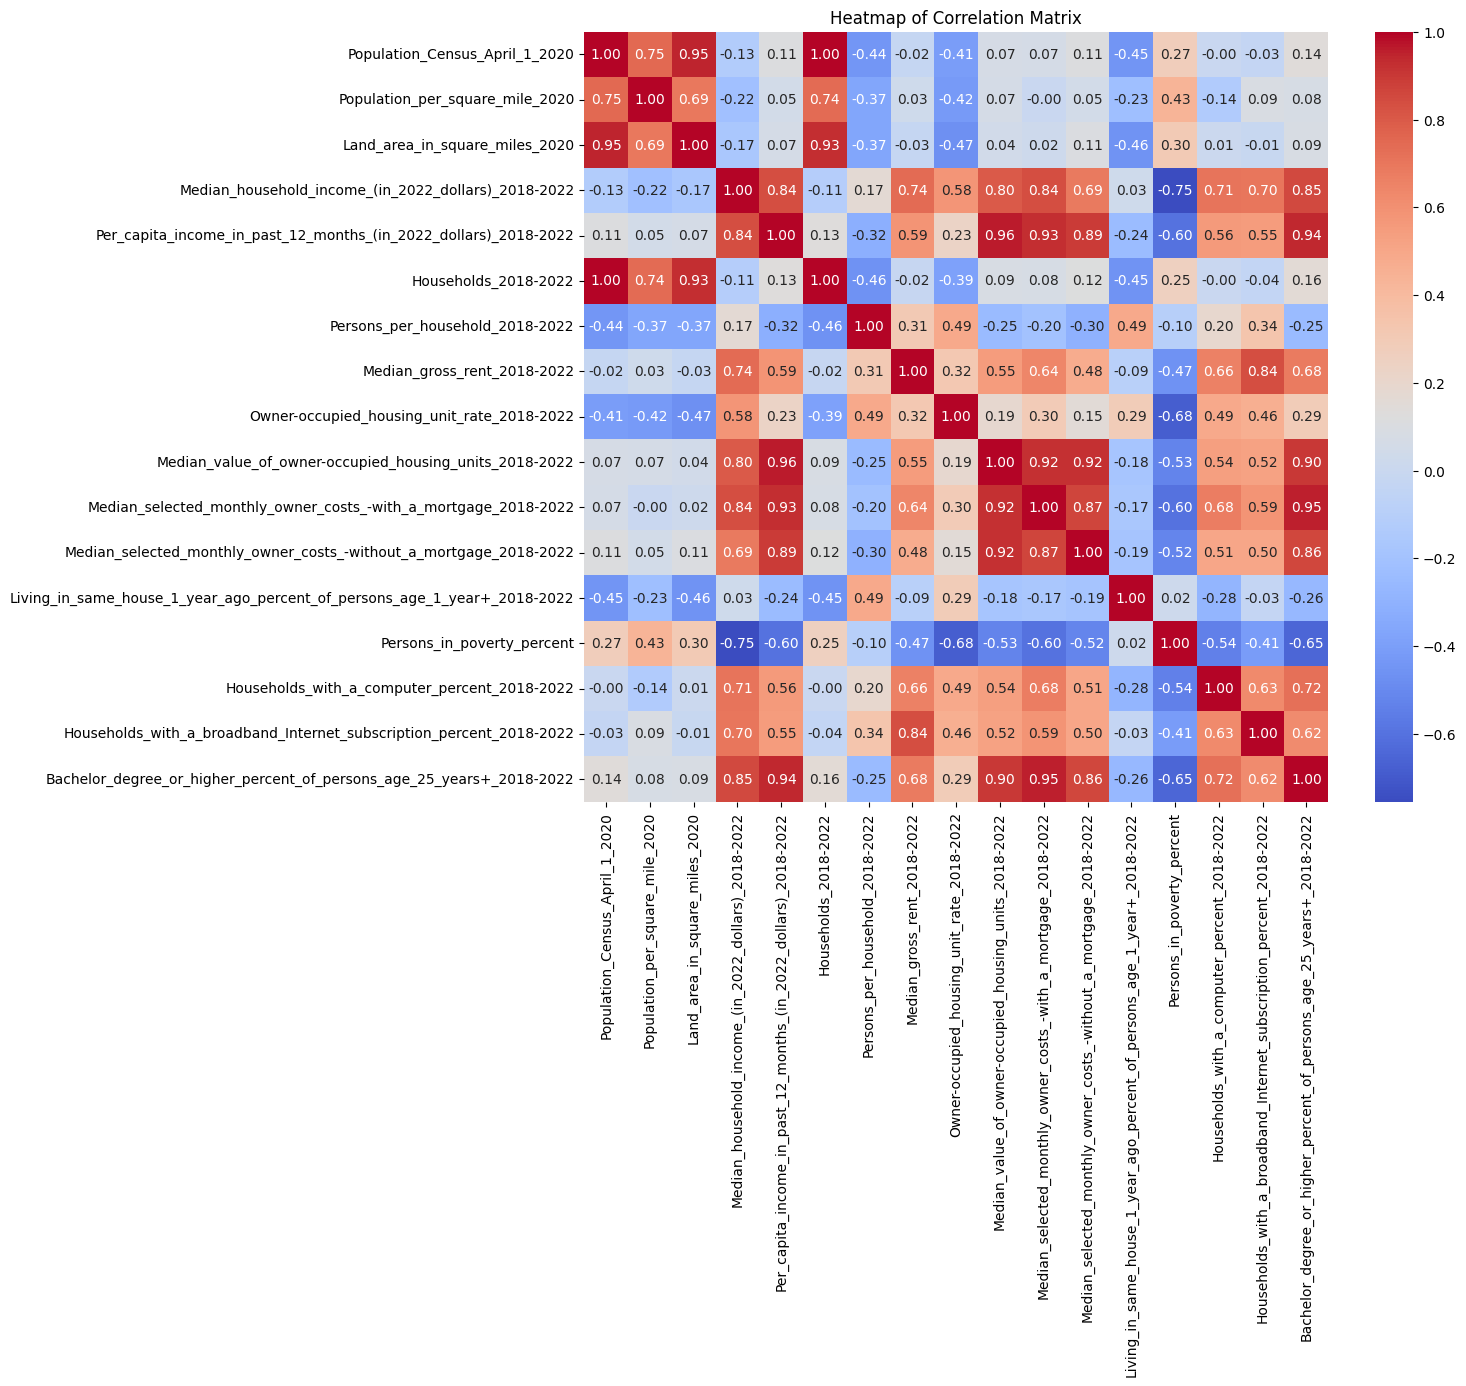

In [39]:
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pop_corr, annot=True, fmt=".2f", cmap='coolwarm')

# Set titles and labels if needed
plt.title('Heatmap of Correlation Matrix')
plt.savefig("pop_correalation.png", dpi=300)
plt.show()

In [40]:
sale_corr = df_kc_house[['sale_price', 'sqft_lot', 'sqft', 'sqft_1', "sqft_fbsmt",'beds', 'bath',
       'land_val',  'grade', 'condition', 'views',
       'stories', 'greenbelt', 'noise_traffic', 'sale_year', 'sale_month', 'age_of_building',
       'years_since_renovation', "if_reno",
       ]].corr()

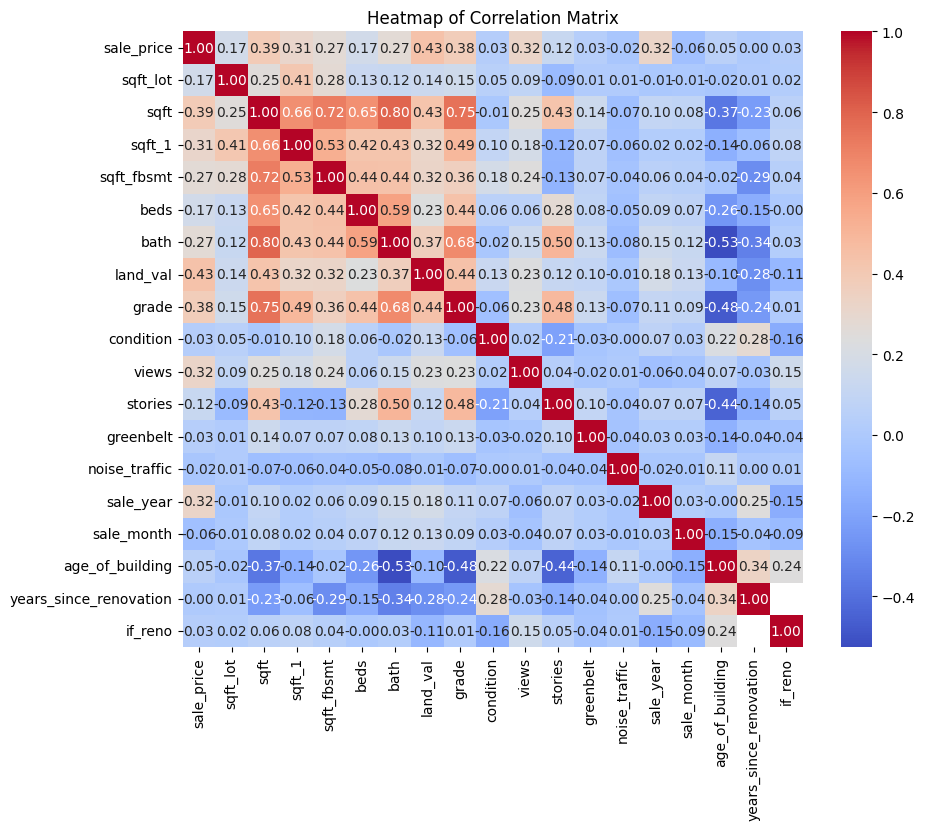

In [41]:
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(sale_corr, annot=True, fmt=".2f", cmap='coolwarm')

# Set titles and labels if needed
plt.title('Heatmap of Correlation Matrix')
# plt.savefig("sale_correalation.png", dpi=300)
plt.show()

In [42]:
# sale_corr.to_csv("sale_correlation.csv")

## 3 Modelling

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
sale_price_mean = df_kc_house['sale_price'].mean()
sale_price_median = df_kc_house['sale_price'].median()

### 3.1 Linear regression

In [45]:
# select sata set 
feature = ["land_val",
                 'sqft_lot', 'sqft', 'sqft_1', 'beds', 'bath', 
                 'grade', 'condition', 'views', 'stories', 
                 'greenbelt', 'noise_traffic', 
                 'sale_year', 'sale_month', 'age_of_building', 
       ]
df = df_kc_house[['sale_price', "land_val",
                 'sqft_lot', 'sqft', 'sqft_1', 'beds', 'bath', 
                 'grade', 'condition', 'views', 'stories', 
                 'greenbelt', 'noise_traffic', 
                 'sale_year', 'sale_month', 'age_of_building', 
       ]]

df = df[df["land_val"]>0]

# Standardize data set
scaler = StandardScaler()
X = scaler.fit_transform(df[feature])  # predictors
y = df["sale_price"]  # response

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the model
lg = LinearRegression()
ridge = Ridge(alpha=1.0)
lg.fit(X_train, y_train)

LinearRegression()

In [46]:

# calculate predictions with test set
lg_predictions = lg.predict(X_test)

# Check the model's performance
print("Model coefficients:", lg.coef_)
print("Model intercept:", lg.intercept_)

Model coefficients: [165667.96816212  33947.85311585 125028.90014826  48711.41366763
 -55127.7267636  -18645.81404489 129376.16095206 -34664.57211913
 131414.04847745  28726.51227877  -7064.4501928  -14938.00516012
 202140.66947725 -59435.25883428 149100.23466376]
Model intercept: 884752.1072000894


In [47]:
# calculate error metrix with test set
lg_r2 = r2_score(y_test, lg_predictions)
lg_mse = mean_squared_error(y_test, lg_predictions)
lg_rmse = mean_squared_error(y_test, lg_predictions, squared=False)  # squared=False returns RMSE
lg_mae = mean_absolute_error(y_test, lg_predictions)

print(f"R-squared: {lg_r2}")
print(f"Mean Absolute Error: {lg_mae}")
print(f"Mean Squared Error: {lg_mse}")
print(f"Root Mean Squared Error: {lg_rmse}")
print(f"Performance: {min(lg_rmse, lg_mse, lg_mae) / max(sale_price_mean, sale_price_median)}")

R-squared: 0.40966306201884695
Mean Absolute Error: 327369.1308842709
Mean Squared Error: 333873528194.773
Root Mean Squared Error: 577817.902279579
Performance: 0.3702875402408232


c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
feat_imp_lg = pd.DataFrame({
    "feature": feature,
    "coef":lg.coef_
}).sort_values("coef",ascending=False)
print("Feature Importance of Linear regression: ", feat_imp_lg)

Feature Importance of Linear regression:              feature           coef
12        sale_year  202140.669477
0          land_val  165667.968162
14  age_of_building  149100.234664
8             views  131414.048477
6             grade  129376.160952
2              sqft  125028.900148
3            sqft_1   48711.413668
1          sqft_lot   33947.853116
9           stories   28726.512279
10        greenbelt   -7064.450193
11    noise_traffic  -14938.005160
5              bath  -18645.814045
7         condition  -34664.572119
4              beds  -55127.726764
13       sale_month  -59435.258834


In [49]:
# feat_imp_lg.to_csv("lg_feature_importance.csv", index=False)

### 3.2 LightGBM

In [50]:
data = df_kc_house[['sale_price', "city", 'sqft_lot', 'sqft', 'sqft_1', "sqft_fbsmt",'beds', 'bath',
       'land_val',  'grade', 'condition', 'views',
       'stories', 'greenbelt', 'noise_traffic', 'sale_year', 'sale_month', 'age_of_building',
       'years_since_renovation', "if_reno",
       ]]

# Encode categorical features
categorical_features = ['city']
label_encoders = {}
for cat_feature in categorical_features:
    label_encoders[cat_feature] = LabelEncoder()
    data[cat_feature] = label_encoders[cat_feature].fit_transform(data[cat_feature])

# Split the data
features = ['city','sqft_lot', 'sqft', 'sqft_1', "sqft_fbsmt",'beds', 'bath',
       'land_val',  'grade', 'condition', 'views',
       'stories', 'greenbelt', 'noise_traffic', 'sale_year', 'sale_month', 'age_of_building',
       'years_since_renovation', "if_reno",]
X = data[features]
y = data['sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\xueke\AppData\Local\Temp\ipykernel_79556\1582163964.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat_feature] = label_encoders[cat_feature].fit_transform(data[cat_feature])


In [51]:
# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])


In [52]:
predictions = bst.predict(X_test, num_iteration=bst.best_iteration)
lgbm_r2 = r2_score(y_test, predictions)
lgbm_mse = mean_squared_error(y_test, predictions)
lgbm_rmse = mean_squared_error(y_test, predictions, squared=False)  # squared=False returns RMSE
lgbm_mae = mean_absolute_error(y_test, predictions)

print(f"R-squared: {lgbm_r2}")
print(f"Mean Absolute Error: {lgbm_mae}")
print(f"Mean Squared Error: {lgbm_mse}")
print(f"Root Mean Squared Error: {lgbm_rmse}")
print(f"Performance: {min(lgbm_mae, lgbm_mse, lgbm_mae) / max(sale_price_mean, sale_price_median)}")

R-squared: 0.7233636575928523
Mean Absolute Error: 195608.6145368848
Mean Squared Error: 162543142138.1994
Root Mean Squared Error: 403166.39510033495
Performance: 0.2212530928958718


c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:
# Calculate Split and Gain Importance
split_importance = bst.feature_importance(importance_type='split')
gain_importance = bst.feature_importance(importance_type='gain')

# Normalize both (optional, to bring them to a similar scale)
split_importance_normalized = split_importance / split_importance.sum()
gain_importance_normalized = gain_importance / gain_importance.sum()

# Combine the two metrics (simple average here)
combined_importance = (split_importance_normalized + gain_importance_normalized) / 2

# Normalize each type of importance by their maximum value
split_importance_normalized_2 = split_importance / np.max(split_importance)
gain_importance_normalized_2 = gain_importance / np.max(gain_importance)

# Multiply the normalized importances
combined_importance_2 = split_importance_normalized_2 * gain_importance_normalized_2

# Create a DataFrame for feature importances
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Split_Importance': split_importance,
    'Gain_Importance': gain_importance,
    'Sum_Importance': combined_importance,
    "Prod_Importance": combined_importance_2
})

# Sort by combined importance
feature_imp = feature_imp.sort_values(by='Sum_Importance', ascending=False)

# Display or plot
feature_imp


,Feature,Split_Importance,Gain_Importance,Sum_Importance,Prod_Importance
7,land_val,636,6.449451e+16,0.214179,1.000000
0,city,574,5.795853e+16,0.192896,0.811053
14,sale_year,330,5.347311e+16,0.143558,0.430199
8,grade,176,4.920388e+16,0.110087,0.211121
10,views,205,2.394709e+16,0.074155,0.119681
16,age_of_building,259,1.688246e+16,0.072016,0.106600
2,sqft,164,2.271788e+16,0.065094,0.090831
1,sqft_lot,139,6.275769e+15,0.034136,0.021267
17,years_since_renovation,82,2.760414e+15,0.018612,0.005518
3,sqft_1,79,2.647107e+15,0.017911,0.005098


In [54]:
# feature_imp.to_csv("lgbm_feature_importance.csv", index=False)

### 3.3 KNN

In [55]:

from sklearn.svm import SVC  # Support Vector Classifier for SVM
from sklearn.neighbors import KNeighborsClassifier  # Classifier for KNN
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [56]:
n = 100000
data = df_kc_house[df_kc_house["land_val"].notna()].sample(n)

X = data[feature + ["city"]]
y = data['sale_price']

column_transformer = ColumnTransformer(
    [('category_encoder', OneHotEncoder(), ['city'])],
    remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
knn_pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])
knn_pipeline.fit(X_train, y_train)

c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_encoder',
                                                  OneHotEncoder(),
                                                  ['city'])])),
                ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [58]:

# KNN predictions and evaluation
knn_predictions = knn_pipeline.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))


KNN Classification Report:


c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

              precision    recall  f1-score   support

       54000       0.00      0.00      0.00         0
       55195       0.00      0.00      0.00         0
       57000       0.00      0.00      0.00         0
       58186       0.00      0.00      0.00         0
       59771       0.00      0.00      0.00         0
       60000       0.00      0.00      0.00         0
       60697       0.00      0.00      0.00         1
       65000       0.33      0.33      0.33         3
       66667       0.00      0.00      0.00         1
       69990       0.00      0.00      0.00         1
       70000       0.00      0.00      0.00         3
       74000       0.00      0.00      0.00         0
       75000       0.00      0.00      0.00         1
       77000       0.00      0.00      0.00         0
       77200       0.00      0.00      0.00         1
       78000       0.00      0.00      0.00         1
       79500       0.00      0.00      0.00         0
       80000       0.00    

c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
knn_r2 = r2_score(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)  # squared=False returns RMSE
knn_mae = mean_absolute_error(y_test, knn_predictions)
print(f"R-squared: {knn_r2}")
print(f"Mean Absolute Error: {knn_mae}")
print(f"Mean Squared Error: {knn_mse}")
print(f"Root Mean Squared Error: {knn_rmse}")
print(f"Performance: {min(knn_mae, knn_mse, knn_mae) / max(sale_price_mean, sale_price_median)}")

R-squared: 0.4299994927741665
Mean Absolute Error: 273539.23855
Mean Squared Error: 340401693219.55316
Root Mean Squared Error: 583439.5369012569
Performance: 0.3094004970121447


c:\Users\xueke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
